<a href="https://colab.research.google.com/github/ebsenthil/KD-IND-HACK/blob/main/kd_hack_inv_predict_AI_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [419]:
!pip install langchain_openai
!pip install langchain_community
!pip install pyowm
!pip install langgraph
!pip install tavily-python
!pip install langchain_tavily


In [650]:
from langchain.tools import tool
import requests
from datetime import datetime, timedelta
import os

In [651]:
# Access the secret
from google.colab import userdata

tavily_api_key = userdata.get('TAVILY_API_KEY')
openai_api_key = userdata.get('OPENAI_API_KEY')
TAVILY_API_KEY = userdata.get("TAVILY_API_KEY")
GOOGLE_API_KEY=userdata.get("GOOGLE_API_KEY")


In [652]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo",api_key=openai_api_key)  # or "gpt-3.5-turbo"
response = llm.invoke("hi")
print(response.content)

Hello! How can I help you today?


In [653]:
!git clone https://github.com/ebsenthil/KD-IND-HACK.git


Cloning into 'KD-IND-HACK'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 816.92 KiB | 4.42 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [654]:
%cd KD-IND-HACK


/content/KD-IND-HACK/KD-IND-HACK/KD-IND-HACK


In [425]:
!ls


feature_columns.pkl	salesdata.py
inventory_predictor.py	synthetic_retail_sales_data.csv
label_encoders.pkl	xgboost_inventory_model.pkl
retail-1.ipynb


In [655]:
from inventory_predictor import InventoryPredictor

predictor = InventoryPredictor(
    model_path="xgboost_inventory_model.pkl",
    encoders_path="label_encoders.pkl",
    features_path="feature_columns.pkl",
    historical_data_path="synthetic_retail_sales_data.csv"
)


Inventory Predictor initialized successfully!


In [656]:
result = predictor.predict_simple(
    product_id='SKU002',
    date='2025-10-20',
    festival_event='Strike',
    natural_disaster='Flood_warning',
    weather_event='Heavy_Rain'
)

print(f"Predicted Sales: {result['predicted_sales']} units")


Predicted Sales: 469 units


In [659]:
import requests
from datetime import datetime

CALENDAR_ID = "en.indian%23holiday@group.v.calendar.google.com"  # India Holiday Calendar
@tool
def get_holidays_on_date(date: str) -> str:
    """
    Fetches public holidays or festival_event in India for a specific date (yyyy-mm-dd).

    Args:
        date (str): Date in 'YYYY-MM-DD' format.

    Returns:
        str: Holiday name(s) which is festival_event or message if none found.
    """
    try:
        # Parse date and prepare RFC3339 format
        dt = datetime.strptime(date, "%Y-%m-%d")
        time_min = dt.strftime("%Y-%m-%dT00:00:00Z")
        time_max = dt.strftime("%Y-%m-%dT23:59:59Z")

        url = (
            f"https://www.googleapis.com/calendar/v3/calendars/{CALENDAR_ID}/events"
            f"?key={GOOGLE_API_KEY}&timeMin={time_min}&timeMax={time_max}"
            f"&singleEvents=true&orderBy=startTime"
        )

        response = requests.get(url)
        data = response.json()
        events = data.get("items", [])

        if not events:
            return f"No public holidays on {date} in India."

        result = f"Holidays on {date} in India:\n"
        for event in events:
            result += f"- {event['summary']}\n"

        return result.strip()

    except Exception as e:
        return f"Error: {str(e)}"


In [660]:
import requests
from datetime import datetime

from langchain.tools import tool

@tool
def get_weather_forecast(city: str, start: str, end: str) -> str:
    """
    Get weather forecast for a city between start and end dates (YYYY-MM-DD).
    Falls back if the date is beyond forecast range.
    """
    start_date = datetime.strptime(start, "%Y-%m-%d")
    end_date = datetime.strptime(end, "%Y-%m-%d")
    today = datetime.today()

    if (start_date - today).days > 15:
        return (
            f"Sorry, I can only fetch forecasts up to 15 days ahead. "
            f"{start} is too far in the future. Would you like historical averages instead?"
        )

    # Example for Chennai (for simplicity)
    latitude = 13.08
    longitude = 80.27

    url = (
        f"https://api.open-meteo.com/v1/forecast?"
        f"latitude={latitude}&longitude={longitude}"
        f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum"
        f"&timezone=auto&start_date={start}&end_date={end}"
    )

    response = requests.get(url)
    data = response.json()

    if 'daily' not in data:
        return "No weather data available for the specified range."

    # Format the weather output nicely
    daily = data['daily']
    forecast = ""
    for i in range(len(daily['time'])):
        forecast += (
            f"{daily['time'][i]}:\n"
            f"- Max Temp: {daily['temperature_2m_max'][i]}°C\n"
            f"- Min Temp: {daily['temperature_2m_min'][i]}°C\n"
            f"- Rainfall: {daily['precipitation_sum'][i]} mm\n\n"
        )

    return forecast.strip()


In [661]:
# Tavily tool
from tavily import TavilyClient

client = TavilyClient(api_key=TAVILY_API_KEY)

@tool
def search_economic_events(city: str) -> str:
    """
    Search economic events like Policy_Change,Fuel_Price_Hike,Strike,Tax_Change.
    Returns a summary string.
    """
    query = f"Search economic events like Policy_Change,Fuel_Price_Hike,Strike,Tax_Change etc in  {city}"
    try:
        response = client.search(query=query, search_depth="advanced", include_answer=True)
        return response.get("answer", "No summary available.")
    except Exception as e:
        return f"Error during search: {e}"


In [662]:
# Tavily tool
from tavily import TavilyClient

client = TavilyClient(api_key=TAVILY_API_KEY)

@tool
def search_disaster_events(city: str) -> str:
    """
    Search natural disaster such as Flood warnning, cycle alert etc,
    Returns a summary string.
    """
    query = f"Search natural disaster such as Flood warnning, cycle alert etc in  {city}"
    try:
        response = client.search(query=query, search_depth="advanced", include_answer=True)
        return response.get("answer", "No summary available.")
    except Exception as e:
        return f"Error during search: {e}"


In [663]:
# Tavily tool
from tavily import TavilyClient

client = TavilyClient(api_key=TAVILY_API_KEY)

@tool
def search_weather_events(city: str) -> str:
    """
    Search weather events like Heavy_rain, Heatwave, storm etc
    Returns a summary string.
    """
    query = f"Search weather events like Heavy_rain, Heatwave, storm etc in  {city}"
    try:
        response = client.search(query=query, search_depth="advanced", include_answer=True)
        return response.get("answer", "No summary available.")
    except Exception as e:
        return f"Error during search: {e}"


In [580]:
from langchain.tools import tool
from datetime import datetime
import requests

@tool
def get_weather_forecast_old(city: str, start: str, end: str) -> str:
    """
    Get weather forecast for a city between start and end dates.
    If the date is beyond forecastable range, return a friendly message.
    """
    # Parse and check date
    today = datetime.today()
    start_date = datetime.strptime(start, "%Y-%m-%d")

    if (start_date - today).days > 14:
        return (
            f"I couldn't retrieve the weather forecast for {city.title()} on {start} "
            f"as it falls beyond the forecastable range. "
            f"If you need information within the next 14 days, feel free to ask!"
        )

    # Coordinates for Chennai (replace with real geocoding for more cities)
    coords = {
        "chennai": {"lat": 13.08, "lon": 80.27},
    }
    city_key = city.lower()

    if city_key not in coords:
        return f"Sorry, I currently don't support weather data for '{city}'."

    lat = coords[city_key]["lat"]
    lon = coords[city_key]["lon"]

    url = (
        f"https://api.open-meteo.com/v1/forecast?"
        f"latitude={lat}&longitude={lon}&daily=temperature_2m_max,temperature_2m_min,"
        f"precipitation_sum&timezone=auto&start_date={start}&end_date={end}"
    )

    response = requests.get(url)
    if response.status_code != 200:
        return f"Failed to fetch weather data. API returned status code {response.status_code}."

    data = response.json()
    forecast = data.get("daily", {})
    if not forecast or not forecast.get("temperature_2m_max"):
        return "Weather data not available for the given date range."

    # Extract data for the single date (assuming start == end)
    idx = 0  # Since it's a single-day forecast
    date = forecast["time"][idx]
    temp_max = forecast["temperature_2m_max"][idx]
    temp_min = forecast["temperature_2m_min"][idx]
    rain = forecast["precipitation_sum"][idx]

    return (
        f"Weather forecast for {city.title()} on {date}:\n"
        f"- Max Temp: {temp_max}°C\n"
        f"- Min Temp: {temp_min}°C\n"
        f"- Expected Rainfall: {rain} mm"
    )


In [615]:
from langchain.tools import tool
from inventory_predictor import InventoryPredictor

# Use explicit file paths inside the cloned repo
predictor = InventoryPredictor(
    model_path="xgboost_inventory_model.pkl",
    encoders_path="label_encoders.pkl",
    features_path="feature_columns.pkl",
    historical_data_path="synthetic_retail_sales_data.csv"
)
@tool
def predict_inventory(product_id: str, date: str, festival_event: str) -> str:
    """
    Predict inventory/sales for a given product ID, date, and festival/event.

    Args:
        product_id (str): The SKU or product ID.
        date (str): The date for prediction (YYYY-MM-DD).
        festival_event (str): The name of the festival or event.

    Returns:
        str: Predicted sales in units.
    """
    result = predictor.predict_simple(product_id=product_id, date=date, festival_event=festival_event)
    return f"Predicted Sales for {product_id} on {date} during {festival_event}: {result['predicted_sales']} units"


Inventory Predictor initialized successfully!


In [664]:
from langchain.tools import tool
from inventory_predictor import InventoryPredictor

# Initialize predictor with explicit file paths
predictor = InventoryPredictor(
    model_path="xgboost_inventory_model.pkl",
    encoders_path="label_encoders.pkl",
    features_path="feature_columns.pkl",
    historical_data_path="synthetic_retail_sales_data.csv"
)

@tool
def predict_inventory_enriched(
    product_id: str,
    date: str,
    festival_event: str = "",
    economic_event: str = "",
    natural_disaster: str = "",
    weather_event: str = "",
) -> str:
    """
    Predict inventory/sales for a given product using enriched event metadata.

    Args:
        product_id (str): Product SKU.
        date (str): Date in YYYY-MM-DD.
        festival_event (str): Name of the festival.
        economic_event (str): Economic trigger/event.
        natural_disaster (str): Disaster type like Flood, Cyclone.
        weather_event (str): Weather condition (Rain, Heatwave, etc.).

    Returns:
        str: Predicted sales.
    """

    # Use a new method (or extend predict_simple) if needed to accept all features
    result = predictor.predict_simple(
        product_id=product_id,
        date=date,
        festival_event=festival_event,
        economic_event=economic_event,
        natural_disaster=natural_disaster,
        weather_event=weather_event,
    )

    return (
        f"Predicted Sales for {product_id} on {date} during {festival_event or 'this period'}: "
        f"{result['predicted_sales']} units"
    )


Inventory Predictor initialized successfully!


In [665]:
from langchain.tools import tool
tools = [get_weather_forecast,get_holidays_on_date,search_economic_events,search_disaster_events,search_weather_events,predict_inventory_enriched]
llm_with_tools=llm.bind_tools(tools)

In [666]:
response=llm_with_tools.invoke("find inventory on sep 10th 2025 in chennai based on weather")

In [667]:
response.content

''

In [668]:
response.tool_calls

[{'name': 'get_weather_forecast',
  'args': {'city': 'Chennai', 'start': '2025-09-10', 'end': '2025-09-10'},
  'id': 'call_IWl6D69jh2tnjnktjztsu4PH',
  'type': 'tool_call'}]

In [669]:
SYSTEM_PROMPT = """
You are a helpful assistant tasked with providing accurate weather and contextual information to support inventory prediction.
You should support the following tasks:

1. Provide the weather for a specific city on a specific date.
2. Find whether there is a holiday or festival_event on that date and its importance.
3. Provide the weather forecast or weather_event (like Storm, Heatwave, Heavy_Rain, etc.) for a specific city over a given date range in the format YYYY-MM-DD.
4. Provide the disaster event (like Flood_Warning or Cyclone_Alert) for a specific city over a given date range in the format YYYY-MM-DD.
5. Find economic_event (like Fuel_Price_Hike, Policy_Change, Strike, Tax_Change) for a specific city over a given date range in the format YYYY-MM-DD.
6. Predict inventory/sales for a given product ID, date, and festival_event.

Make sure to extract the city name and date(s) accurately from user queries. Use this information to determine the appropriate tool call. Respond clearly and concisely to assist in inventory forecasting.
"""


In [670]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START

In [671]:
def function_1(state:MessagesState):

    user_question=state["messages"]

    input_question = [SYSTEM_PROMPT]+user_question

    response = llm_with_tools.invoke(input_question)

    return {
        "messages":[response]
    }

In [672]:
builder=StateGraph(MessagesState)
builder.add_node("llm_decision_step",function_1)

In [673]:
from langgraph.prebuilt import ToolNode
builder.add_node("tools",ToolNode(tools))

In [674]:
builder.add_edge(START,"llm_decision_step")

In [675]:
from langgraph.prebuilt import tools_condition
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)

In [676]:
builder.add_edge("tools","llm_decision_step")

In [677]:
react_graph=builder.compile()

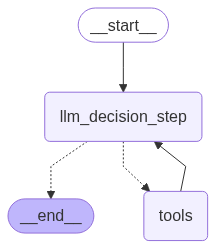

In [678]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [679]:
message=[HumanMessage(content="find inventory on 12th jul 2025 in chennai for SKU010 consider various economic, weather, disaster events, holiday events etc. ")]

In [680]:
weather_result=react_graph.invoke({"messages":message})

In [512]:
weather_result

{'messages': [HumanMessage(content='find inventory based on weather condition on 5th of July 2025 in chennai for SKU010. ', additional_kwargs={}, response_metadata={}, id='ff3174cb-1e0b-40e4-b65b-0806576b05fb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yUBcXDlD1oZFpGF7U5dPgABW', 'function': {'arguments': '{"city":"Chennai","start":"2025-07-05","end":"2025-07-05"}', 'name': 'get_weather_forecast'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 322, 'total_tokens': 357, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BoAIF5dODjIAtzDKY85Qcx1gtURQJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6057e5d2-bcd5-4650-827

In [681]:
for m in weather_result["messages"]:
    m.pretty_print()

================================ Human Message =================================

find inventory on 12th jul 2025 in chennai for SKU010 consider various economic, weather, disaster events, holiday events etc. 
================================== Ai Message ==================================
Tool Calls:
  get_weather_forecast (call_XIbAbSjy7aRE7MTLatyHi88b)
 Call ID: call_XIbAbSjy7aRE7MTLatyHi88b
  Args:
    city: Chennai
    start: 2025-07-12
    end: 2025-07-12
================================= Tool Message =================================
Name: get_weather_forecast

2025-07-12:
- Max Temp: 37.3°C
- Min Temp: 28.5°C
- Rainfall: 0.0 mm
================================== Ai Message ==================================
Tool Calls:
  get_holidays_on_date (call_C5cYorX3LzNFSTb17gR6CGNn)
 Call ID: call_C5cYorX3LzNFSTb17gR6CGNn
  Args:
    date: 2025-07-12
  search_disaster_events (call_AnBYllxY8rKfo8ZriQTqdLCG)
 Call ID: call_AnBYllxY8rKfo8ZriQTqdLCG
  Args:
    city: Chennai
  search_economi

In [682]:
from IPython.display import Markdown, display

response = weather_result["messages"][-1].content
display(Markdown(response))  # For Jupyter or Colab

Based on the analysis for Chennai on July 12, 2025:
- **Weather Forecast**: The weather is expected to have a maximum temperature of 37.3°C, a minimum temperature of 28.5°C, and no rainfall.
- **Holiday Events**: There are no public holidays or festival events on this date.
- **Disaster Events**: Chennai frequently faces flood warnings and cyclone alerts due to its vulnerability to natural disasters. The city has a flood warning system in place.
- **Economic Events**: Ola and Uber drivers went on strike due to fuel price hikes, highlighting economic disruptions caused by fuel price increases.

### Inventory Prediction:
With the considerations of a Fuel Price Hike and Flood Warning:
- **Predicted Sales for SKU010**: 356 units.

This prediction takes into account the economic and disaster events impacting sales on July 12, 2025, in Chennai.